# Getting Started with Jupyter Notebook for MRI Diagnosis

This notebook will guide you through the basics of using Jupyter Notebook and set up a workflow for MRI image diagnosis using PyTorch.

In [1]:
%pip install notebook

# Check if Jupyter is installed and display its version
try:
    import notebook
    print(f"Jupyter Notebook version: {notebook.__version__}")
except ImportError:
    print("Jupyter Notebook is not installed.")

Note: you may need to restart the kernel to use updated packages.
Jupyter Notebook version: 7.4.5
Note: you may need to restart the kernel to use updated packages.
Jupyter Notebook version: 7.4.5


## Launch Jupyter Notebook

To launch Jupyter Notebook from your terminal, run:

```
jupyter notebook
```

This will open the Jupyter interface in your web browser.

## Create a New Notebook

In the Jupyter interface, click the 'New' button and select 'Python 3' to create a new notebook.

## Rename the Notebook

To rename your notebook, click on the notebook title at the top and enter a new name, such as `mri_diagnosis_starter`.

## Add and Run Code Cells

To add a new code cell, click the '+' button or use the menu. Enter Python code and press Shift+Enter to run the cell and see the output below it.

In [3]:
# Import required libraries for MRI diagnosis
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models 
from torch.utils.data import DataLoader, Dataset

In [6]:
# Define data transforms and load MRI datasets

data_dir = '../data'  # Adjust path if needed

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # If images are not already grayscale
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

Number of training samples: 5712
Number of test samples: 1311


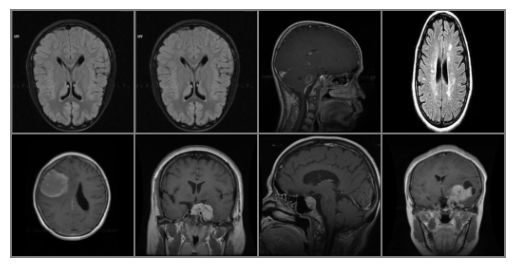

Labels: [2 2 0 2 1 1 3 1]


In [8]:
import torchvision

# Visualize a batch of MRI images
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.axis('off')
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_loader))

# Show images
imshow(torchvision.utils.make_grid(images[:8], nrow=4))
print('Labels:', labels[:8].numpy())

In [9]:
# Define a simple CNN model for MRI classification

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

num_classes = len(train_dataset.classes)
model = SimpleCNN(num_classes)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [10]:
# Set up loss function, optimizer, and device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training loop

epochs = 5  # Increase for better results
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/5, Loss: 0.7129
Epoch 2/5, Loss: 0.3493
Epoch 2/5, Loss: 0.3493
Epoch 3/5, Loss: 0.2328
Epoch 3/5, Loss: 0.2328
Epoch 4/5, Loss: 0.1351
Epoch 4/5, Loss: 0.1351
Epoch 5/5, Loss: 0.0920
Epoch 5/5, Loss: 0.0920


In [12]:
# Evaluate the model on the test set

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 93.59%


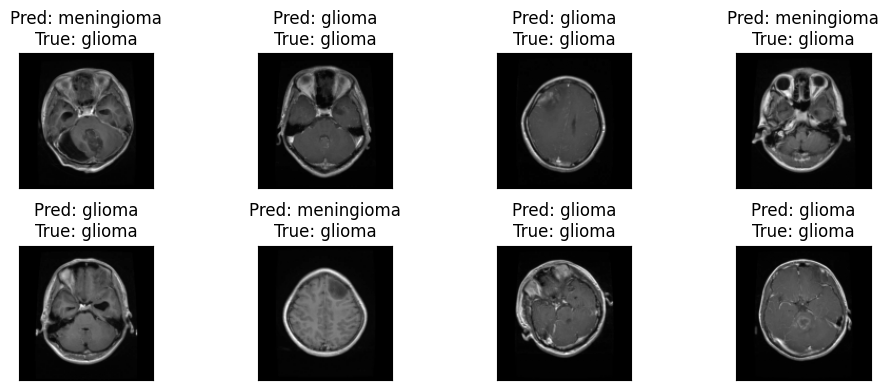

In [13]:
# Visualize predictions on a few test images

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 4))
for idx in range(8):
    ax = fig.add_subplot(2, 4, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy().squeeze()
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Pred: {train_dataset.classes[preds[idx]]}\nTrue: {train_dataset.classes[labels[idx]]}")
plt.tight_layout()
plt.show()